# 首先，载入相关需要的函数模块，以及书写必要的函数。
    由于keras.layers~applications等模块中的大部分函数都被使用到，这边方便起见，直接整体导入，否则不建议整体导入函数模块。
    设定随机数种子，方便以下数据shuffle时始终同序列，便于复现结果。
    为了绘制history曲线，这里利用callback函数设定一个"loss","acc"list，并声明。

In [1]:
import cv2
import os
import glob
import h5py
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import GlobalAveragePooling2D
np.random.seed(2016)

class LossHistory(Callback): 
    def on_train_begin(self, logs={}):
        self.losses = [] 
        self.val_losses = [] 
        self.acces = [] 
        self.val_acces = [] 

    def on_epoch_end(self, batch, logs={}): 
        self.losses.append(logs.get('loss')) 
        self.val_losses.append(logs.get('val_loss')) 
        self.acces.append(logs.get('acc')) 
        self.val_acces.append(logs.get('val_acc')) 

History = {}

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 数据预处理
    项目所设计的图片数据，是基于整体图像进行训练学习的，图片相似度很高，很容易过拟合——这是数据库决定的。那么这里通过基于司机进行训练集和验证集的分类，减少出现把司机外观特征作为判别特征的可能性。
    建立data文件夹，train，validation，test子文件夹，并创建不同类别'c0'~'c9'多个类别文件夹。根据司机名称放入相应文件夹中，这里训练集：测试集≈22:4。

In [2]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

def transfer_image(driver,targetpath):
    path = "./imgs/train"
    images = datacsv.loc[(datacsv['subject']==driver),['img']]
    classnames = datacsv.loc[(datacsv['subject']==driver),['classname']] 

    for i in range(len(images)):
        resource = "".join(os.path.join(path,classnames.values[i][0],images.values[i][0]))
        target = "".join(os.path.join(targetpath,classnames.values[i][0],images.values[i][0]))
        shutil.copy(resource,target)
    return len(images)

# 根据驾驶员分割训练集和验证集
x_drivers = []
y_drivers = []
datacsv = pd.read_csv('driver_imgs_list.csv')
x_drivers = datacsv['subject'].unique()[:22]
y_drivers = datacsv['subject'].unique()[22:]

# 重新建立目标文件树
rmrf_mkdir("./data")
print('/data/ recreate') 
os.makedirs("./data/test/val")
for c in ["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]: 
    os.makedirs("./data/train/{0}".format(c))
    os.makedirs("./data/validation/{0}".format(c))
print('folders created !') 

# 复制文件到目标文件夹下
tra_nb = 0
val_nb = 0
for driver in x_drivers:
    tra_nb += transfer_image(driver, targetpath="./data/train")
print ("train_data transfer is finished")
for driver in y_drivers:
    val_nb += transfer_image(driver,targetpath="./data/validation/")
print ("validation_data transfer is finished")
for file in os.listdir("./imgs/test/"):
    resource = "".join(os.path.join("./imgs/test/",file))
    target = "".join(os.path.join("./data/test/val",file))
    shutil.copy(resource,target)
tex_nb = len(os.listdir("./data/test/val/"))
print ("test_data transfer is finished")
print (tra_nb, val_nb, tex_nb)

/data/ recreate
folders created !
train_data transfer is finished
validation_data transfer is finished
test_data transfer is finished
19407 3017 79726


# 数据增强
    利用ImageDataGenerator，generator进行数据增强。

In [3]:
gen = ImageDataGenerator()
train_gen = ImageDataGenerator(rotation_range=10.,width_shift_range=0.05,
                               height_shift_range=0.05,shear_range=0.1,zoom_range=0.1)
train_generator = train_gen.flow_from_directory("./data/train",  (299, 299), shuffle=True, batch_size=32, class_mode="categorical")
valid_generator = gen.flow_from_directory("./data/validation",  (299, 299), shuffle=True, batch_size=32, class_mode="categorical")

Found 19407 images belonging to 10 classes.
Found 3017 images belonging to 10 classes.


# 预训练模型相关函数书写     
    建立预训练模型调用函数；
    建立模型预测函数；
    为了可视化，调试发现问题，这里调用反馈预训练模型中的权重值并绘制热成像图。

In [4]:
def Model_fit(size,MODEL,preprocess_fun,optimizer,History,tune=0,Epochs=10,drop=0.3):
    width = size[0]
    height = size[1]
    input_tensor = Input((height, width, 3))
    x = Lambda(preprocess_fun)(input_tensor)
        
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    new_output = GlobalAveragePooling2D()(base_model.output)
    new_output = Dropout(drop)(new_output)
    new_output = Dense(10, activation="softmax")(new_output)
    new_model = Model(base_model.input, new_output)
    if tune:
        new_model.load_weights("./a_%s.hdf5"%MODEL.__name__)
        
    new_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     new_model.summary()

    history = LossHistory()
    earlystopping = EarlyStopping(monitor="val_loss", min_delta=0.0003, patience=5, verbose=1, mode="min")
    if tune:
        checkpoint = ModelCheckpoint("./%s.hdf5"%MODEL.__name__,monitor="val_loss", mode="min", save_best_only=True, period=1)
    else:
        checkpoint = ModelCheckpoint("./a_%s.hdf5"%MODEL.__name__,monitor="val_loss", mode="min", save_best_only=True, period=1)

    model = new_model.fit_generator(train_generator, train_generator.samples//32+1, Epochs, verbose=1,
                                    validation_data=valid_generator, callbacks=[history,earlystopping,checkpoint])
    
    History["%s"%MODEL.__name__] = model.history
    print("Finish!")
    return new_model

def predict_csv(model, model_image_size,csv_name):
    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory("./data/test", model_image_size, shuffle=False, batch_size=32, class_mode=None)
    
    y_pred = model.predict_generator(test_generator, test_generator.samples//32+1,  verbose=1)
    print("y_pred shape {}".format(y_pred.shape))
    y_pred = y_pred.clip(min=0.005, max=0.995)

    acc = []
    for i, fname in enumerate(test_generator.filenames):
        name = fname[fname.rfind('/')+1:]
        acc.append( [name,y_pred[i][0],y_pred[i][1],y_pred[i][2],y_pred[i][3],y_pred[i][4],
                     y_pred[i][5],y_pred[i][6],y_pred[i][7],y_pred[i][8],y_pred[i][9]] )

    df = pd.DataFrame(acc,columns=['img'] + ['c%d'%i for i in range(10)])
    df.head(10)
    df = df.sort_values(by='img')
    df.to_csv(csv_name,index=None, float_format='%.3f')
    print("csv saved")

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    image_files = glob.glob(os.path.join("./data/test/val/","*"))
    print(len(image_files))
    
    plt.figure(figsize=(12, 24))
    for i in range(10):
        plt.subplot(5, 2, i+1)
        img = cv2.imread(image_files[200*i+113])
        img = cv2.resize(img, (299, 299))
        x = img.copy().astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        
        max_idx = np.argmax(predictions)
        prediction = predictions[max_idx]

        status = ["safe_driving",  " texting_right",  "phone_right",  "texting_left",  "phone_left",  
                  "operation_radio", "drinking", "reaching_behind", "hair_and_makeup", "talking"]

        plt.title('c%d |%s| %.2f%%' % (max_idx , status[max_idx], prediction*100))
    
        cam = (prediction - 0.5) * np.matmul(out[0], weights_show)
        cam = ((cam[:,:,max_idx]-cam.min())/cam.max()-0.2)/0.8
        cam = cv2.resize(cam, (299, 299))
        
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
    pass

#heatmap for the output of model
def heatmap(model):
    visual_layer = len(model.layers)-4
    final_layer = len(model.layers)-1
    weights = model.layers[final_layer].get_weights()[0]
    layer_output = model.layers[visual_layer].output
    model2 = Model(model.input, [layer_output, model.output])
    print("layer_output {0}".format(layer_output))
    print("weights shape {0}".format(weights.shape))
    show_heatmap_image(model2, weights)
    pass
print("done")

done


# 开放预训练模型，选择合适权重
      书写完以上主要函数后，剩下就可以正式开始模型的训练和合适的模型权重的选择，并进行模型融合，提高训练预测效果。这里主要使用了InceptionV3，InceptionResnetV2，Xception三个预训练模型进行训练和用于模型融合。
      关于单模型的训练通过：
      1.提取较好“val_loss”&“loss”表现的一组权重（val_loss较低同时loss并没有完全收敛，虽然训练中只提取保留val_loss最低的一组权重，但还是会通过多次筛选，最终选择表现最好的一组权重），这里主要通过adam优化器，减少调参压力；
      2.在提取权重基础上利用sgd定向收敛，进一步提高模型的效果；
      3.在载入训练好的模型进行测试集预测。
      由于最佳权重的提取都是通过多次训练得到的，这里就不再重新跑再次提取了。
      之后，通过heatmap观察预测效果。
      不过通过观察heatmap我们发现有些动作本身存在很大迷惑性，即使我们自己也很难判断，更不用说机器了。

In [10]:
#InceptionV3，选出合适的h5py
adam = Adam(lr=0.0002)
new_model =  Model_fit((299,299),InceptionV3,inception_v3.preprocess_input,adam,History,Epochs=10,tune=0,drop=0.4)

Epoch 1/10
607/607 [==============================] - 436s 718ms/step - loss: 0.1823 - acc: 0.9433 - val_loss: 1.0639 - val_acc: 0.7378
Epoch 2/10
607/607 [==============================] - 415s 683ms/step - loss: 0.0369 - acc: 0.9894 - val_loss: 0.6929 - val_acc: 0.8068
Epoch 3/10
607/607 [==============================] - 415s 684ms/step - loss: 0.0288 - acc: 0.9918 - val_loss: 0.3863 - val_acc: 0.8886
Epoch 4/10
607/607 [==============================] - 415s 684ms/step - loss: 0.0284 - acc: 0.9919 - val_loss: 0.5454 - val_acc: 0.8336
Epoch 5/10
607/607 [==============================] - 415s 684ms/step - loss: 0.0231 - acc: 0.9936 - val_loss: 0.4957 - val_acc: 0.8615
Epoch 6/10
607/607 [==============================] - 416s 685ms/step - loss: 0.0171 - acc: 0.9946 - val_loss: 0.6359 - val_acc: 0.8150
Epoch 7/10
607/607 [==============================] - 415s 684ms/step - loss: 0.0219 - acc: 0.9936 - val_loss: 0.9390 - val_acc: 0.7663
Epoch 8/10
607/607 [============================

Epoch 1/12
607/607 [==============================] - 426s 702ms/step - loss: 0.0548 - acc: 0.9853 - val_loss: 0.3614 - val_acc: 0.8757
Epoch 2/12
607/607 [==============================] - 411s 677ms/step - loss: 0.0429 - acc: 0.9882 - val_loss: 0.3421 - val_acc: 0.8787
Epoch 3/12
607/607 [==============================] - 410s 675ms/step - loss: 0.0335 - acc: 0.9907 - val_loss: 0.3388 - val_acc: 0.8777
Epoch 4/12
607/607 [==============================] - 410s 676ms/step - loss: 0.0331 - acc: 0.9913 - val_loss: 0.3325 - val_acc: 0.8797
Epoch 5/12
607/607 [==============================] - 410s 676ms/step - loss: 0.0283 - acc: 0.9922 - val_loss: 0.3298 - val_acc: 0.8800
Epoch 6/12
607/607 [==============================] - 411s 677ms/step - loss: 0.0247 - acc: 0.9932 - val_loss: 0.3299 - val_acc: 0.8803
Epoch 7/12
607/607 [==============================] - 411s 677ms/step - loss: 0.0229 - acc: 0.9933 - val_loss: 0.3249 - val_acc: 0.8823
Epoch 8/12
607/607 [============================

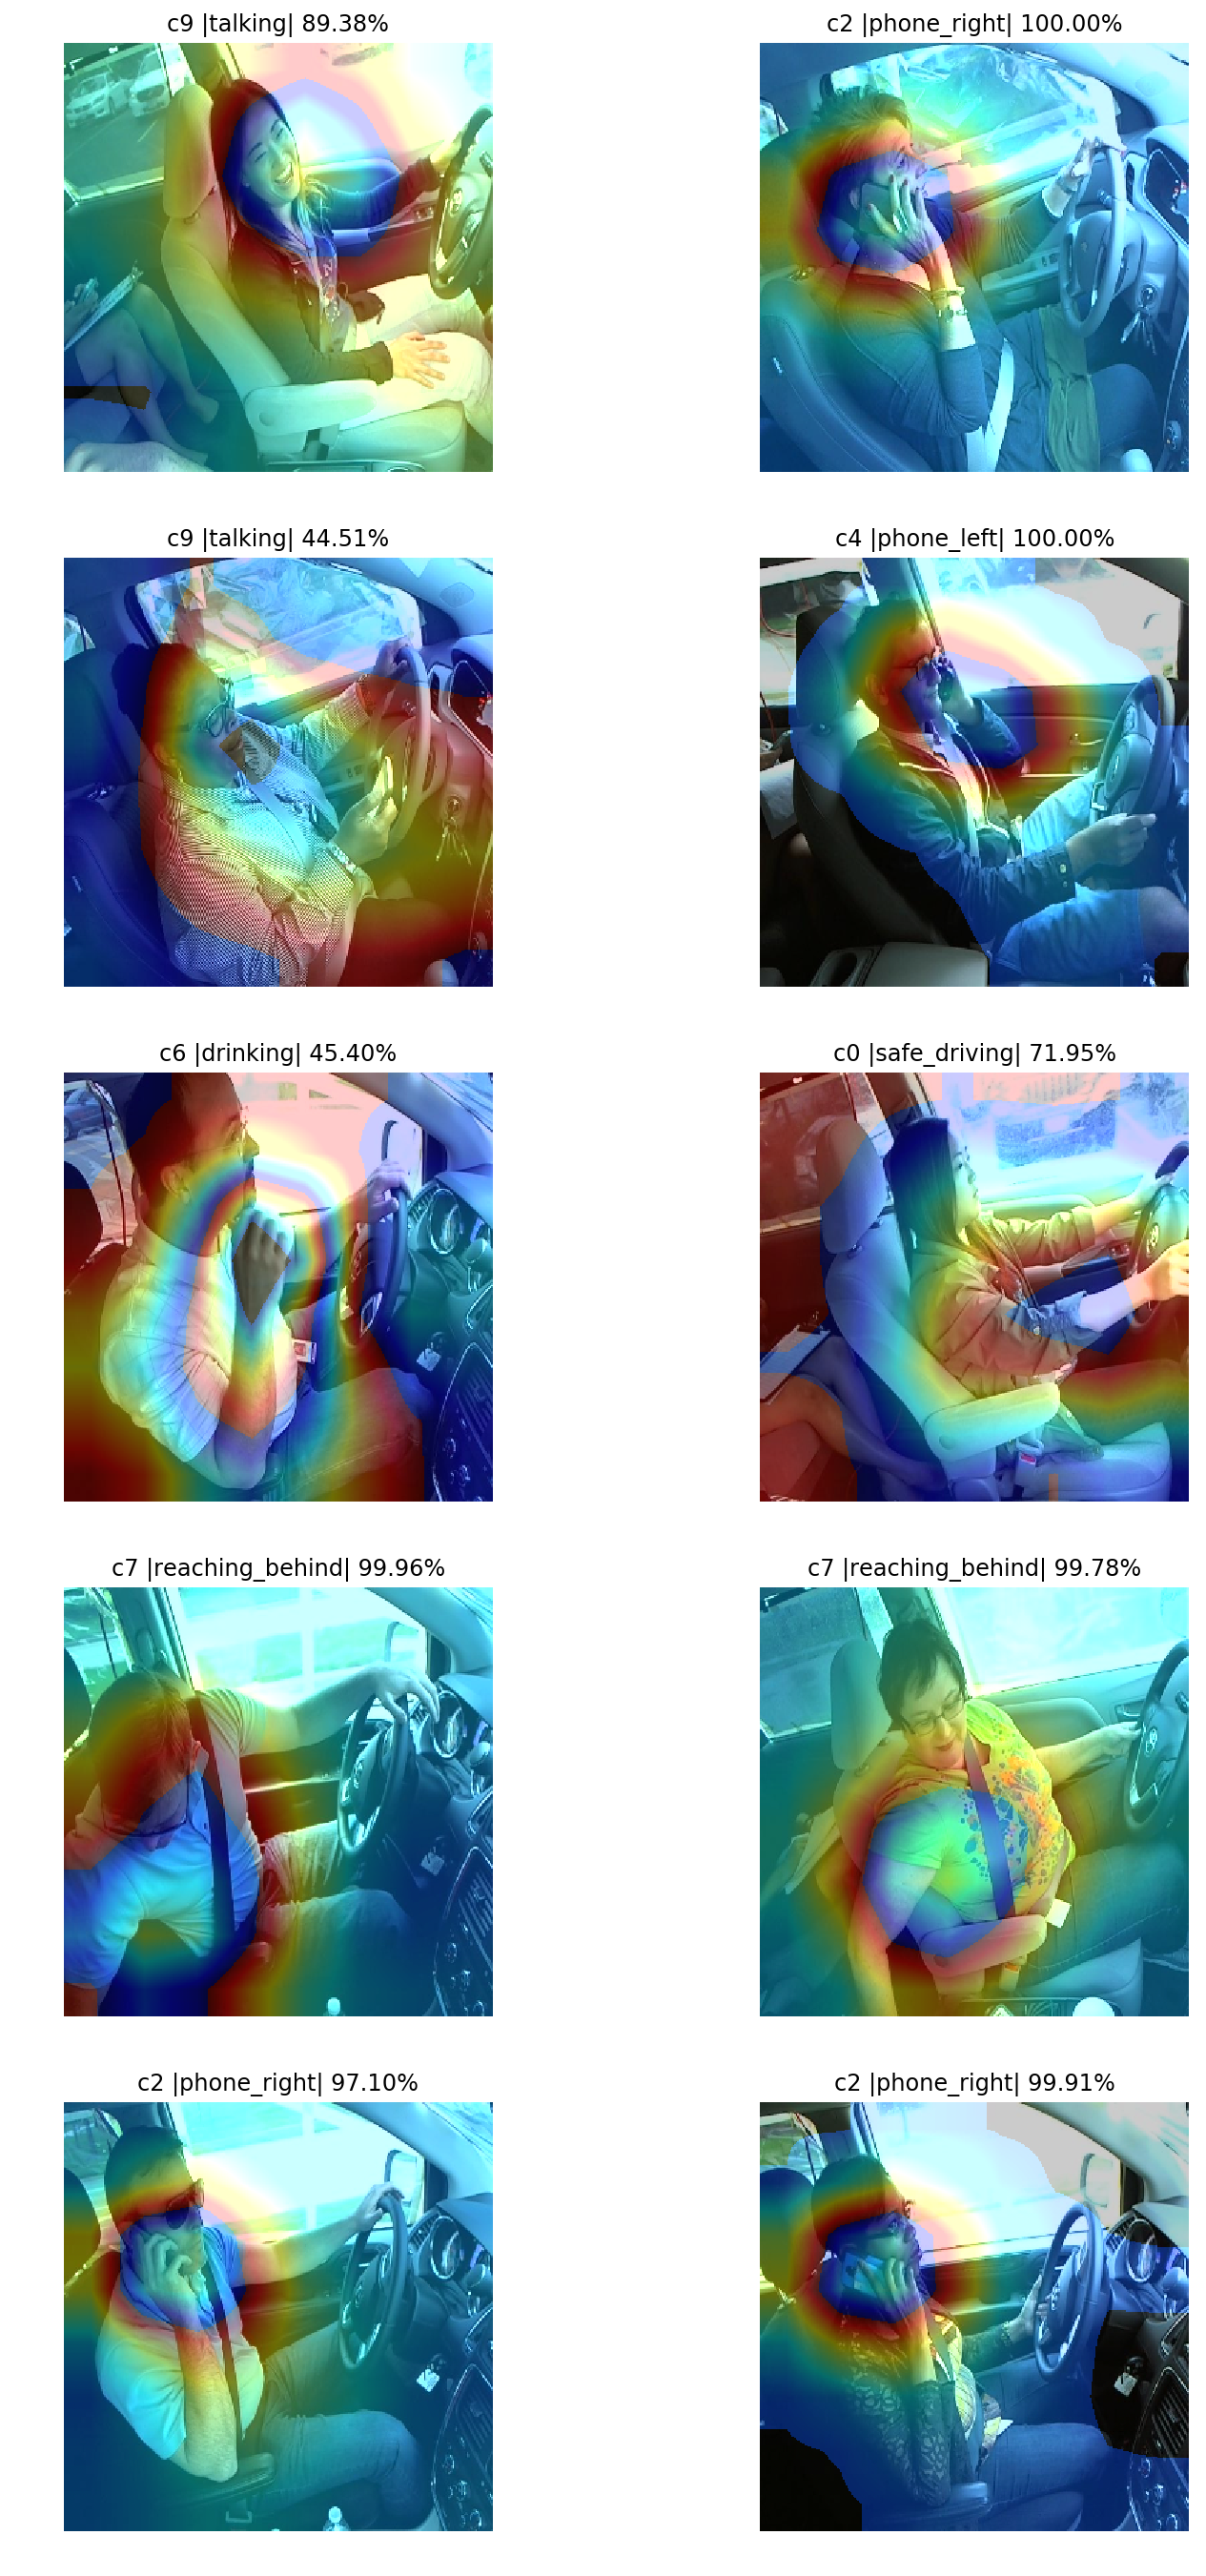

In [6]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
new_model =  Model_fit((299,299),InceptionV3,inception_v3.preprocess_input,sgd,History,tune=1,Epochs=12,drop=0.4)
predict_csv(new_model,(299, 299),'pred1.csv')
heatmap(new_model)

In [6]:
#IncetionResNetV2，选出合适的h5py
adam = Adam(lr=0.0001)
new_model = Model_fit((299,299),InceptionResNetV2,inception_resnet_v2.preprocess_input,adam,History,Epochs=10,tune=0,drop=0.5)

Epoch 1/10
607/607 [==============================] - 506s 834ms/step - loss: 0.2317 - acc: 0.9268 - val_loss: 0.6547 - val_acc: 0.8008
Epoch 2/10
607/607 [==============================] - 451s 743ms/step - loss: 0.0274 - acc: 0.9925 - val_loss: 0.7204 - val_acc: 0.7846
Epoch 3/10
607/607 [==============================] - 451s 743ms/step - loss: 0.0201 - acc: 0.9946 - val_loss: 0.6133 - val_acc: 0.8257
Epoch 4/10
607/607 [==============================] - 451s 743ms/step - loss: 0.0128 - acc: 0.9964 - val_loss: 0.7143 - val_acc: 0.8127
Epoch 5/10
607/607 [==============================] - 451s 743ms/step - loss: 0.0150 - acc: 0.9956 - val_loss: 0.7286 - val_acc: 0.8131
Epoch 6/10
607/607 [==============================] - 451s 743ms/step - loss: 0.0088 - acc: 0.9977 - val_loss: 0.3994 - val_acc: 0.8936
Epoch 7/10
607/607 [==============================] - 451s 743ms/step - loss: 0.0131 - acc: 0.9961 - val_loss: 0.4838 - val_acc: 0.8664
Epoch 8/10
607/607 [============================

Epoch 1/12
607/607 [==============================] - 468s 771ms/step - loss: 0.0105 - acc: 0.9966 - val_loss: 0.3301 - val_acc: 0.9108
Epoch 2/12
607/607 [==============================] - 428s 705ms/step - loss: 0.0099 - acc: 0.9973 - val_loss: 0.3275 - val_acc: 0.9122
Epoch 3/12
607/607 [==============================] - 427s 704ms/step - loss: 0.0083 - acc: 0.9979 - val_loss: 0.3230 - val_acc: 0.9142
Epoch 4/12
607/607 [==============================] - 428s 705ms/step - loss: 0.0089 - acc: 0.9973 - val_loss: 0.3221 - val_acc: 0.9151
Epoch 5/12
607/607 [==============================] - 428s 704ms/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.3245 - val_acc: 0.9125
Epoch 6/12
607/607 [==============================] - 427s 704ms/step - loss: 0.0068 - acc: 0.9981 - val_loss: 0.3259 - val_acc: 0.9115
Epoch 7/12
607/607 [==============================] - 428s 705ms/step - loss: 0.0071 - acc: 0.9977 - val_loss: 0.3244 - val_acc: 0.9122
Epoch 8/12
607/607 [============================

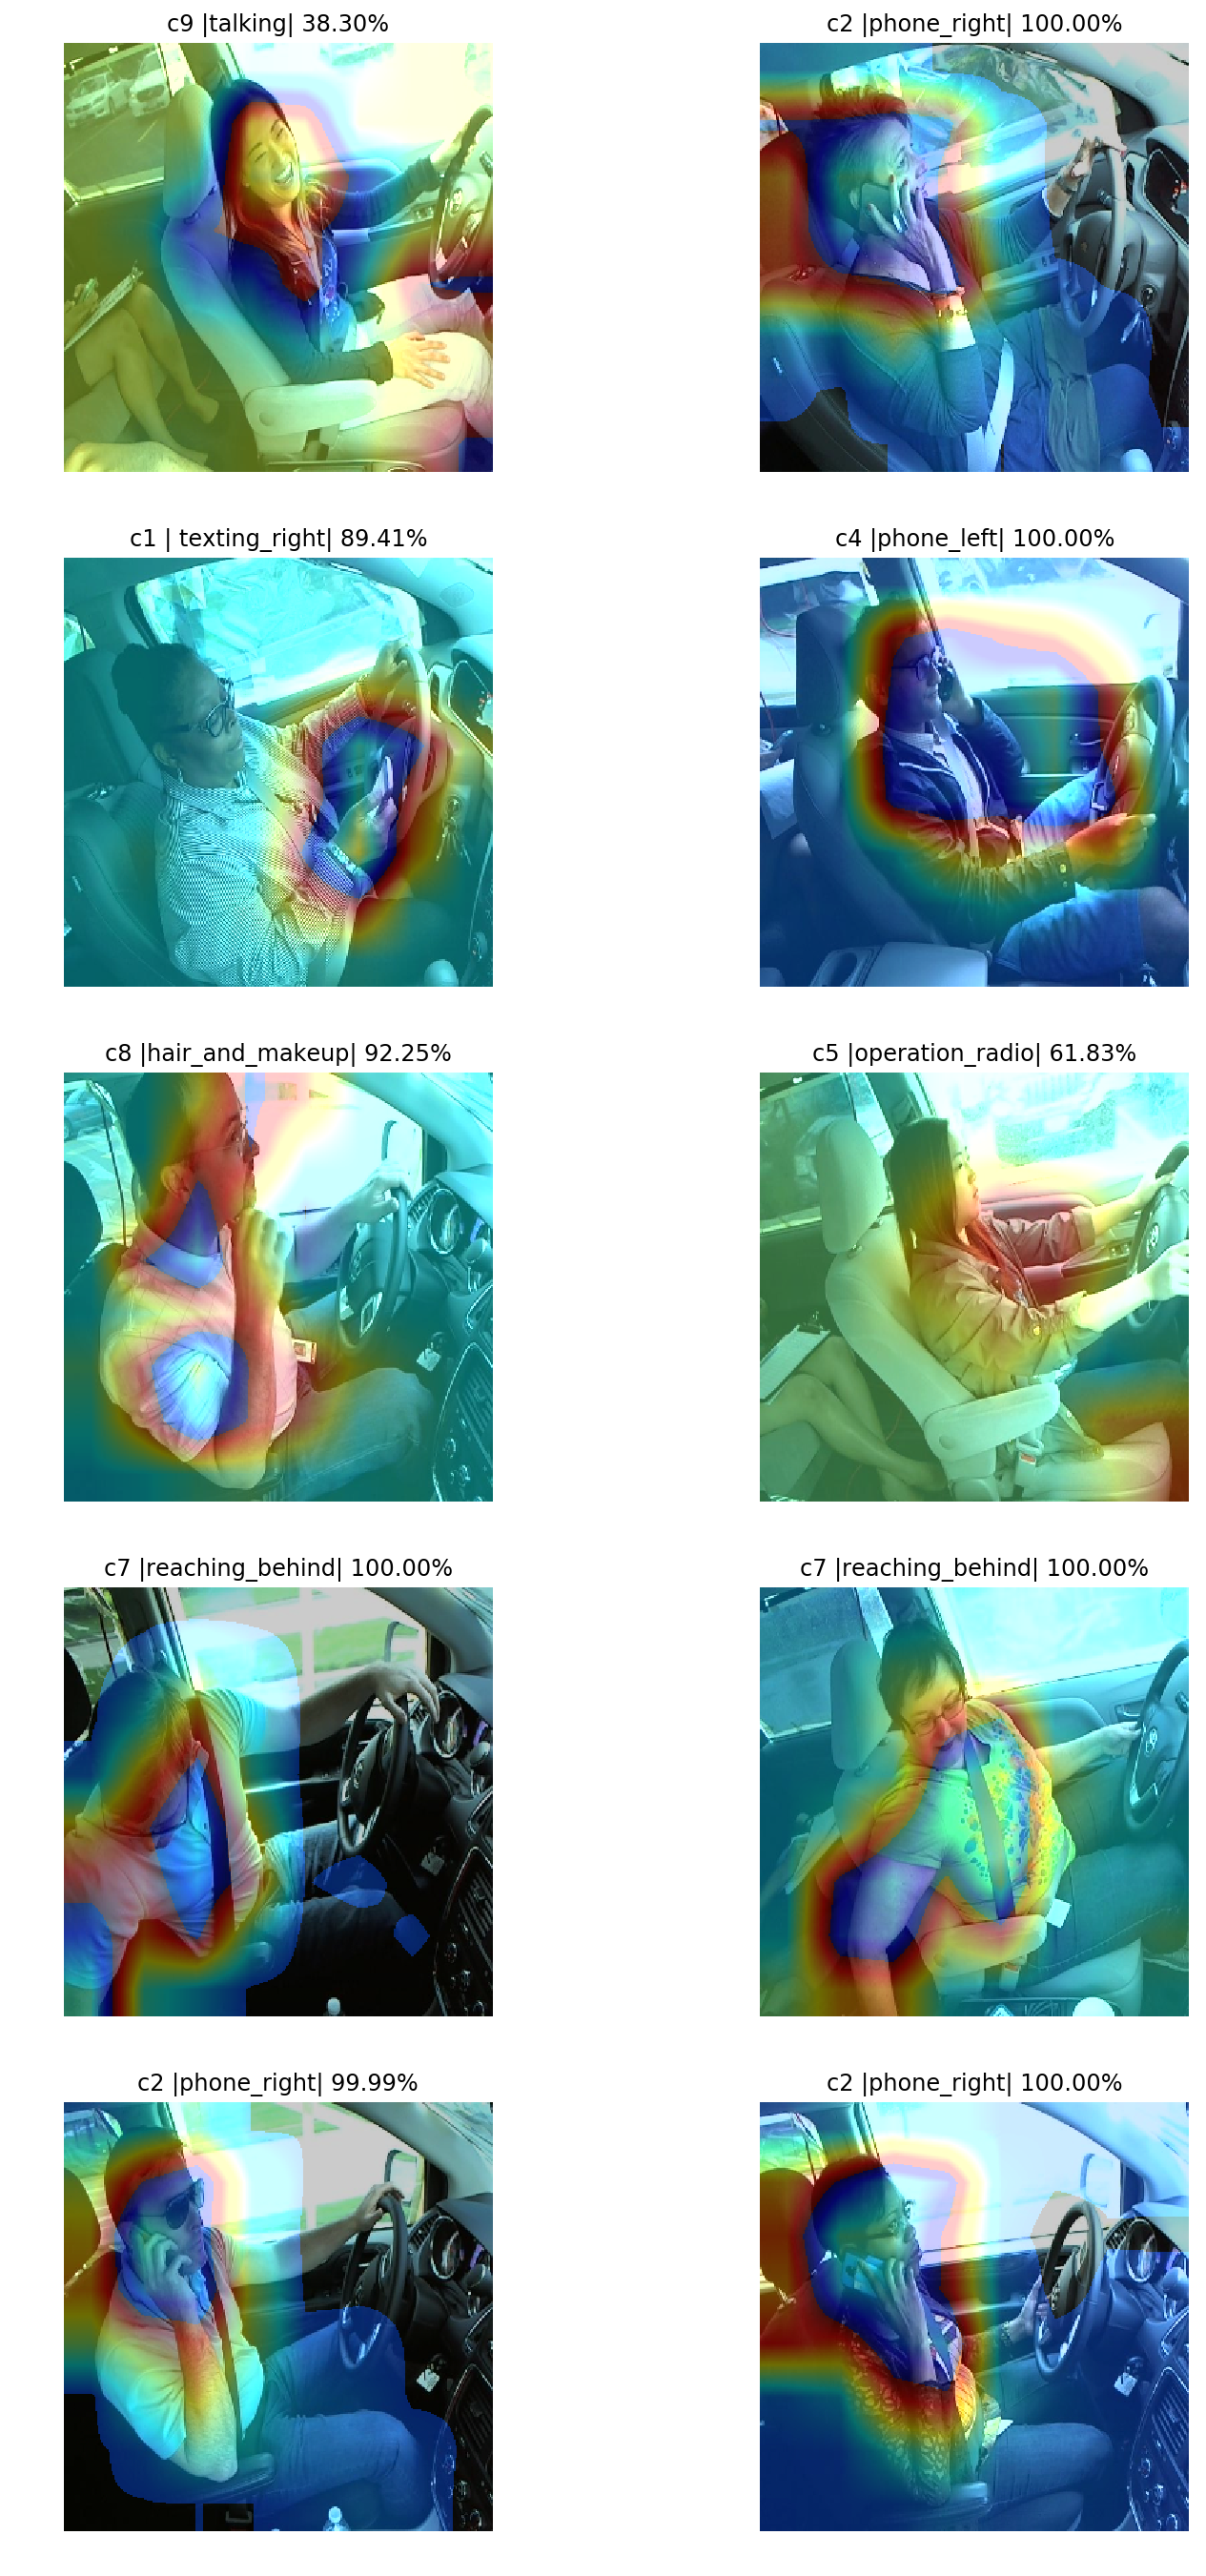

In [7]:
#在adam基础上利用sgd进行精调，降低val_loss，提高val_acc
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
new_model = Model_fit((299,299),InceptionResNetV2,inception_resnet_v2.preprocess_input,sgd,History,tune=1,Epochs=12,drop=0.5)
predict_csv(new_model, (299, 299),'pred2.csv')
heatmap(new_model)

In [10]:
#Xception，选出合适的h5py
adam = Adam(lr=0.00015)
new_model = Model_fit((299,299),Xception,xception.preprocess_input,adam,History,Epochs=10,tune=0,drop=0.5)

Epoch 1/10
607/607 [==============================] - 521s 858ms/step - loss: 0.2682 - acc: 0.9217 - val_loss: 0.7396 - val_acc: 0.7733
Epoch 2/10
607/607 [==============================] - 489s 805ms/step - loss: 0.0237 - acc: 0.9935 - val_loss: 0.5341 - val_acc: 0.8499
Epoch 3/10
607/607 [==============================] - 490s 807ms/step - loss: 0.0101 - acc: 0.9975 - val_loss: 0.4065 - val_acc: 0.8787
Epoch 4/10
607/607 [==============================] - 489s 806ms/step - loss: 0.0066 - acc: 0.9984 - val_loss: 0.5762 - val_acc: 0.8382
Epoch 5/10
607/607 [==============================] - 489s 806ms/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.7191 - val_acc: 0.7730
Epoch 6/10
607/607 [==============================] - 489s 805ms/step - loss: 0.0077 - acc: 0.9979 - val_loss: 0.4290 - val_acc: 0.8777
Epoch 7/10
607/607 [==============================] - 489s 805ms/step - loss: 0.0068 - acc: 0.9980 - val_loss: 0.8186 - val_acc: 0.7885
Epoch 8/10
607/607 [============================

Epoch 1/12
607/607 [==============================] - 492s 811ms/step - loss: 0.0136 - acc: 0.9966 - val_loss: 0.3925 - val_acc: 0.8731
Epoch 2/12
607/607 [==============================] - 478s 787ms/step - loss: 0.0113 - acc: 0.9969 - val_loss: 0.3848 - val_acc: 0.8764
Epoch 3/12
607/607 [==============================] - 478s 787ms/step - loss: 0.0112 - acc: 0.9969 - val_loss: 0.3800 - val_acc: 0.8797
Epoch 4/12
607/607 [==============================] - 478s 788ms/step - loss: 0.0102 - acc: 0.9972 - val_loss: 0.3811 - val_acc: 0.8784
Epoch 5/12
607/607 [==============================] - 478s 788ms/step - loss: 0.0111 - acc: 0.9970 - val_loss: 0.3886 - val_acc: 0.8777
Epoch 6/12
607/607 [==============================] - 478s 788ms/step - loss: 0.0105 - acc: 0.9971 - val_loss: 0.3774 - val_acc: 0.8810
Epoch 7/12
607/607 [==============================] - 478s 788ms/step - loss: 0.0086 - acc: 0.9975 - val_loss: 0.3822 - val_acc: 0.8780
Epoch 8/12
607/607 [============================

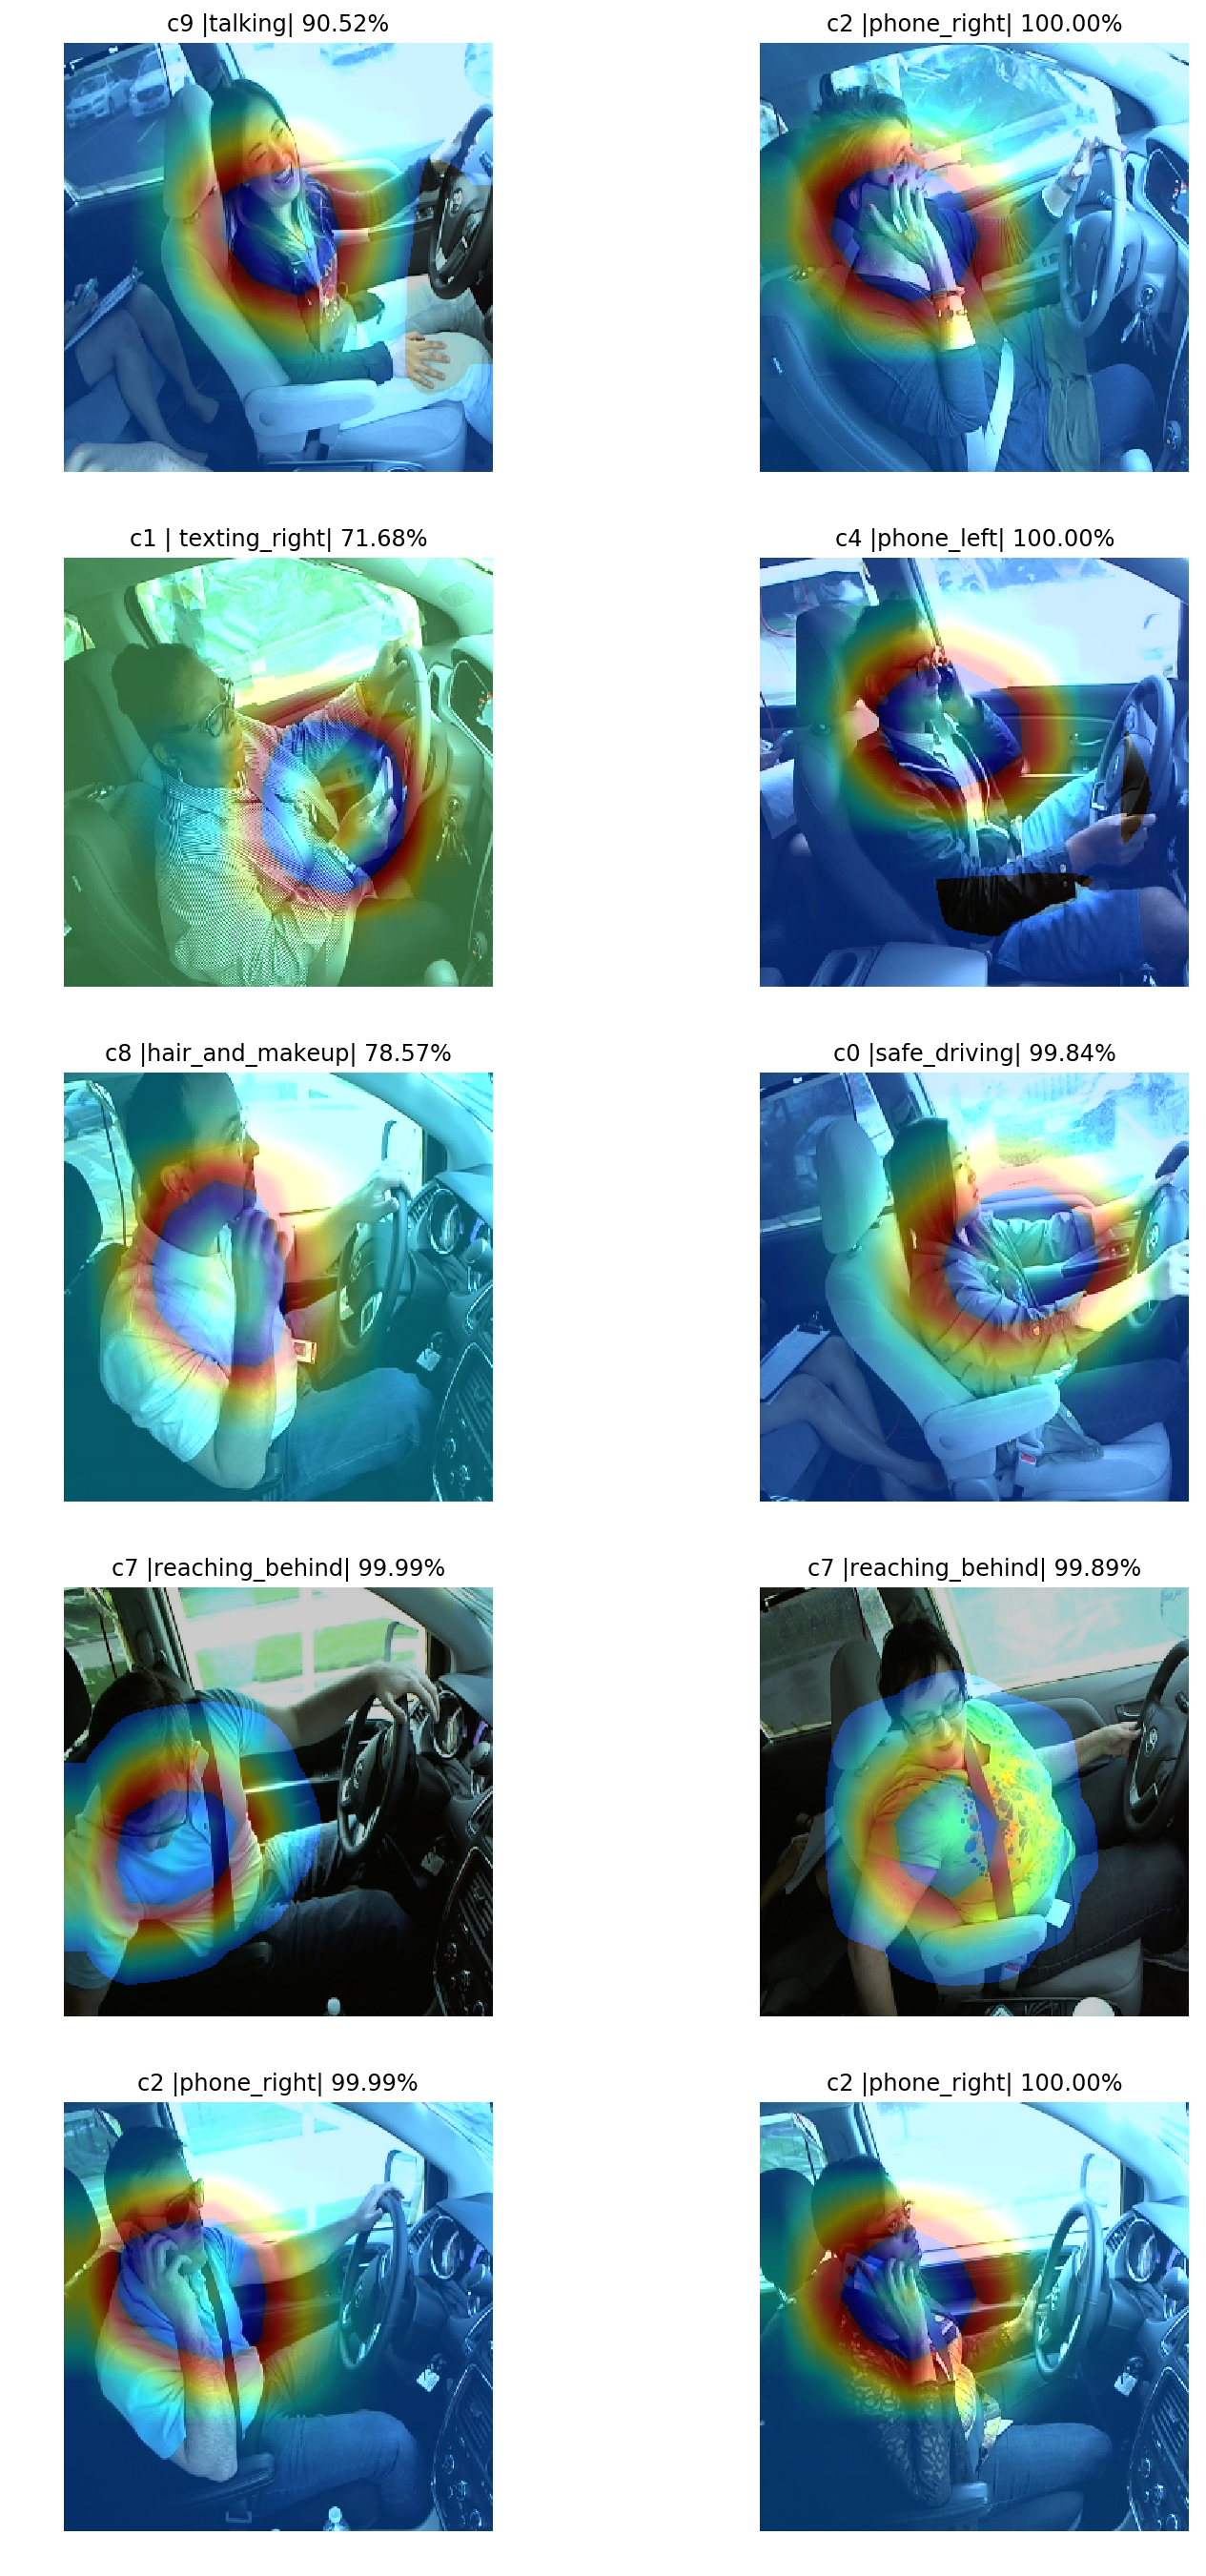

In [8]:
#在adam基础上利用sgd进行精调，降低val_loss，提高val_acc
sgd = SGD(lr=0.00005, decay=1e-6, momentum=0.9, nesterov=True)
new_model = Model_fit((299,299),Xception,xception.preprocess_input,sgd,History,tune=1,Epochs=12,drop=0.5)
predict_csv(new_model, (299, 299),'pred3.csv')
heatmap(new_model)

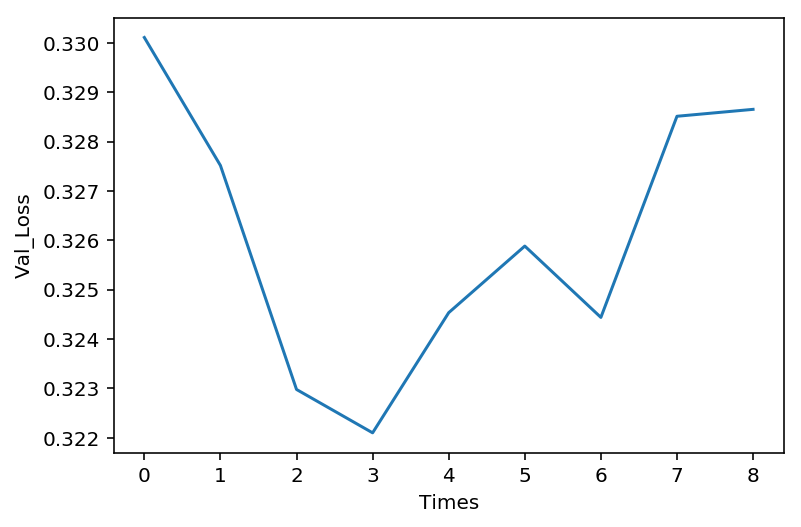

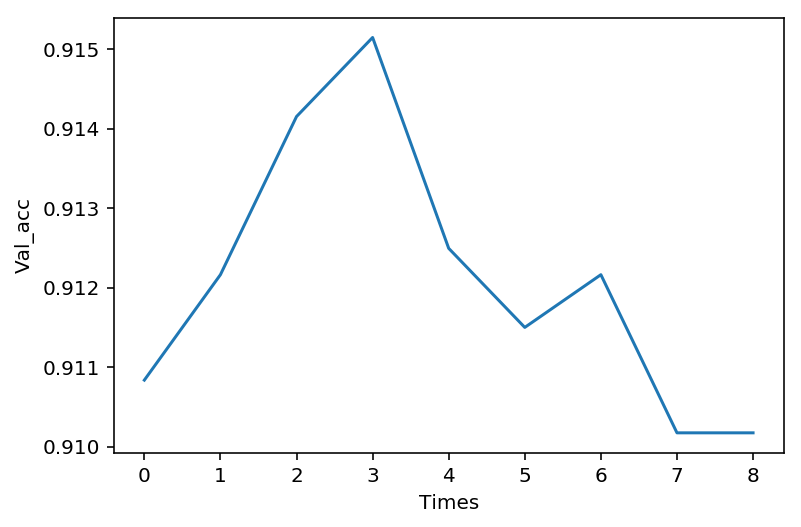

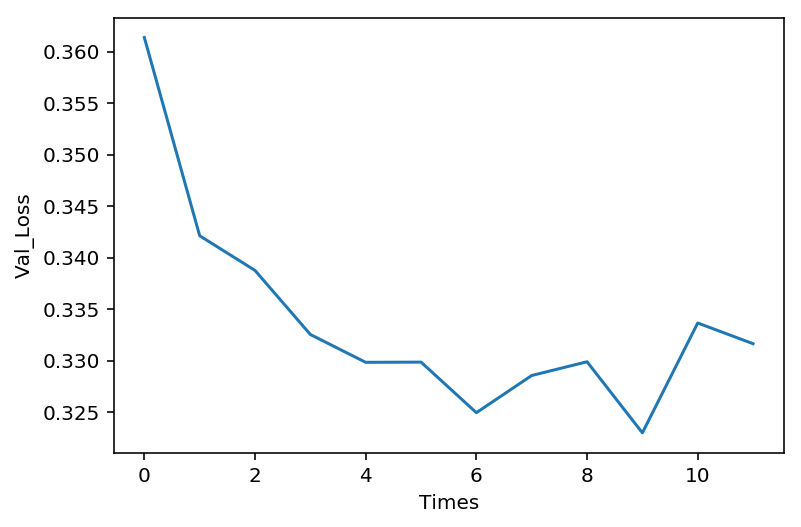

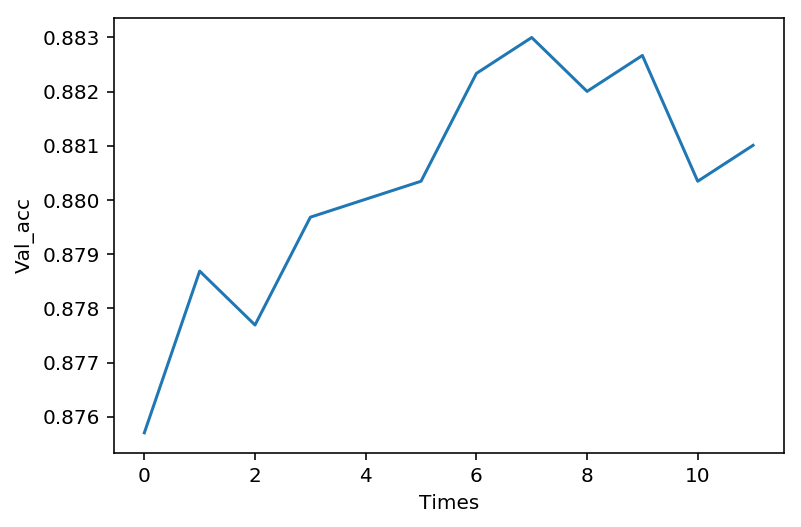

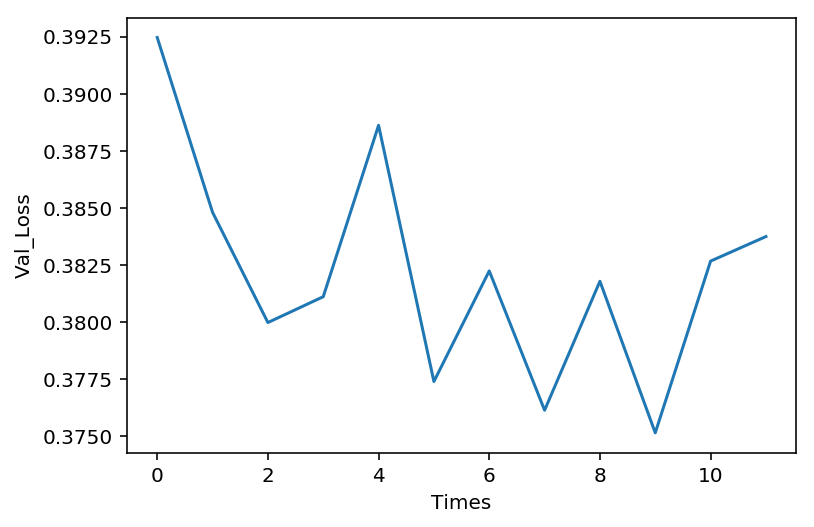

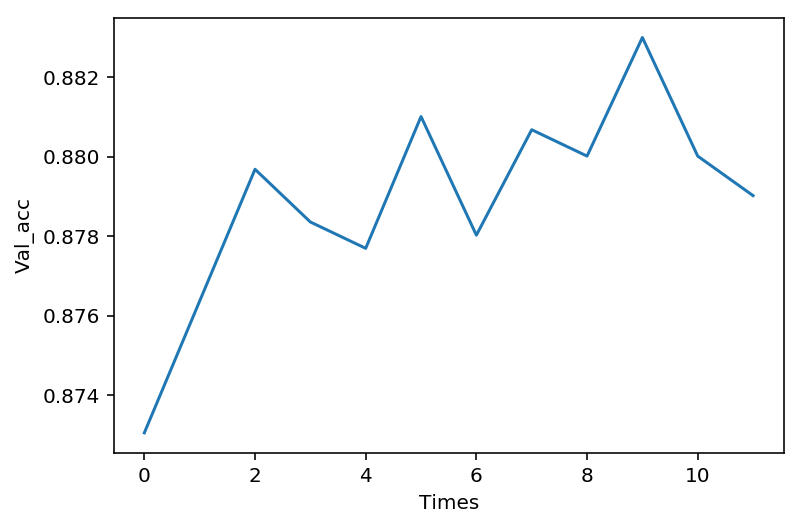

In [11]:
# val_loss学习曲线 & val_acc学习曲线
for t in ["InceptionResNetV2","InceptionV3","Xception"]:
    plt.plot(History[t]['val_loss'])
    plt.xlabel('Times')
    plt.ylabel('Val_Loss')
    plt.show()

    plt.plot(History[t]['val_acc'])
    plt.xlabel('Times')
    plt.ylabel('Val_acc')
    plt.show()

这里直接针对三个模型的导出结果进行均值化处理，得到结果部分显示，从而用于确认运算正确

In [12]:
#平均结果
df = pd.read_csv('sample_submission.csv')
df1 = pd.read_csv('pred1.csv').values[0:,1:]
df2 = pd.read_csv('pred2.csv').values[0:,1:]
df3 = pd.read_csv('pred3.csv').values[0:,1:]
result = (df1+df2+df3)/3
print (result)
index = pd.Index(df.values[:,0],name='img')
df = pd.DataFrame(result,columns=df.columns[1:],index=index)
df.to_csv('pred.csv',float_format='%.3f')
df.head(10)

[[0.005 0.005 0.005 ... 0.005 0.005 0.005]
 [0.005 0.005 0.005 ... 0.005 0.005 0.005]
 [0.9700000000000001 0.007333333333333334 0.005 ... 0.005 0.007
  0.009666666666666667]
 ...
 [0.005 0.005 0.005 ... 0.005 0.005 0.005]
 [0.005 0.005 0.005 ... 0.005 0.005 0.005]
 [0.005 0.005 0.005 ... 0.005 0.005 0.005]]


c0          c1          c2          c3          c4  \
img                                                                        
img_1.jpg          0.005       0.005       0.005       0.005       0.005   
img_10.jpg         0.005       0.005       0.005       0.005       0.005   
img_100.jpg         0.97  0.00733333       0.005  0.00766667       0.005   
img_1000.jpg       0.005       0.005  0.00933333       0.005       0.005   
img_100000.jpg     0.005       0.005       0.005       0.995       0.005   
img_100001.jpg     0.005       0.005       0.005       0.995       0.005   
img_100002.jpg     0.005       0.005       0.005       0.136       0.008   
img_100003.jpg  0.382667       0.005       0.005       0.005  0.00533333   
img_100004.jpg     0.005       0.005       0.005       0.005       0.005   
img_100005.jpg     0.005       0.005       0.005       0.005       0.005   

                   c5     c6          c7        c8          c9  
img                                                             
img_1.jpg       0.995  0.005       0.005     0.005       0.005  
img_10.jpg      0.995  0.005       0.005     0.005       0.005  
img_100.jpg     0.005  0.005       0.005     0.007  0.00966667  
img_1000.jpg    0.005  0.005       0.005      0.99       0.005  
img_100000.jpg  0.005  0.005       0.005     0.005       0.005  
img_100001.jpg  0.005  0.005       0.005     0.005       0.005  
img_100002.jpg  0.005  0.005       0.005  0.631667    0.223667  
img_100003.jpg  0.005  0.005  0.00533333     0.052    0.554667  
img_100004.jpg  0.005  0.995       0.005     0.005       0.005  
img_100005.jpg  0.005  0.005       0.995     0.005       0.005